In [1]:
import numpy as np 
from subprocess import Popen, PIPE, STDOUT
import os
import matplotlib.pyplot as plt
import galsim
import copy 

In [2]:
%pylab inline
from astropy.table import Table
import fitsio

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
#directories that would be using 
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/'
repo = '/Users/Ismael/code/lensing/repo/'

In [4]:
os.chdir(WLD)
width = 512 
height = 512
psf_beta = 3.0 
psf_e1 = 0. #when it is 0 then the sigma matches the fwhm. 
psf_e2 = 0. 
psf_fwhm = .7
airmass = 1.
# pixel_scale = .2
# truncate_radius = 30. 
# min_snr = .05
cd = 1.06502 #disk. 
cb = 10.8396 #bulge 

In [5]:
#produces demo.fits file with partials, 
cmd = ('./simulate.py --catalog-name OneDegSq.fits --image-width {0} --image-height {1} \
--survey-name LSST --filter-band i --output-name demo --verbose --calculate_bias \
--mirror-diameter 0 --atmospheric-psf-beta {2} --atmospheric-psf-e1 {3} --atmospheric-psf-e2 {4} \
--zenith-psf-fwhm {5} --no-bulge --no-agn --airmass {6} --only-id 402700632300 --verbose-model').format(width,height,psf_beta,psf_e1,psf_e2,psf_fwhm,airmass)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print cmd
print output


./simulate.py --catalog-name OneDegSq.fits --image-width 512 --image-height 512 --survey-name LSST --filter-band i --output-name demo --verbose --calculate_bias --mirror-diameter 0 --atmospheric-psf-beta 3.0 --atmospheric-psf-e1 0.0 --atmospheric-psf-e2 0.0 --zenith-psf-fwhm 0.7 --no-bulge --no-agn --airmass 1.0 --only-id 402700632300 --verbose-model
Read 858502 catalog entries from OneDegSq.fits
Simulating LSST i-band survey with {'exposure_time': 6900.0, 'sky_brightness': 20.0, 'mirror_diameter': 0.0, 'airmass': 1.0, 'zero_point': 41.5, 'survey_name': 'LSST', 'image_width': 512, 'filter_band': 'i', 'pixel_scale': 0.2, 'atmospheric_psf_beta': 3.0, 'cosmic_shear_g2': 0.0, 'zenith_psf_fwhm': 0.7, 'image_height': 512, 'effective_area': 33.212, 'extinction': 0.07, 'atmospheric_psf_e1': 0.0, 'cosmic_shear_g1': 0.0, 'atmospheric_psf_e2': 0.0} (obs.frac. = 0.000)
Will render all pixels with at least 33.8 detected electrons.
PSF dilution factor is 0.051823.
Simulation output will be saved to 

In [184]:
catalog = Table.read('demo.fits', hdu=1)
fits = fitsio.FITS('demo.fits')

In [185]:
#example particular columns and conditions out of the fits file. 
print catalog.colnames
selected = ((catalog['grp_size'] == 1) & (catalog['snr_grpf']>20) & (catalog['visible'] == 1))
selected_catalog = catalog[selected]
selected_catalog

['db_id', 'grp_id', 'grp_size', 'grp_rank', 'visible', 'xmin', 'xmax', 'ymin', 'ymax', 'f_disk', 'f_bulge', 'dx', 'dy', 'z', 'ab_mag', 'ri_color', 'flux', 'sigma_m', 'sigma_p', 'e1', 'e2', 'a', 'b', 'beta', 'psf_sigm', 'purity', 'snr_sky', 'snr_iso', 'snr_grp', 'snr_isof', 'snr_grpf', 'ds', 'dg1', 'dg2', 'ds_grp', 'dg1_grp', 'dg2_grp', 'hsm_sigm', 'hsm_e1', 'hsm_e2', 'g1_fit', 'g2_fit']


db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
402700632300,402700632300,1,0,1,161,190,353,382,1.0,0.0,-15.9555,22.4338,1.38524,22.5413,0.43375,1.04996e+06,0.734498,1.04044,-0.559721,0.146625,1.42162,0.379487,1.44269,0.959838,1.0,127.727,126.258,126.258,79.3034,79.3034,0.0166245,0.0146437,0.0146437,0.0166245,0.0146437,0.0146437,nan,nan,nan,0.0,0.0


### Manual checking by entries by forcing what I think are the correct values (look at table above) 

In [186]:
os.chdir(WLD)
wld_model = eval('galsim.Convolve((galsim.Exponential(scale_radius=0.345868148108, flux=1049961.07539)).shift(-0.055495199978,-0.066240169092), galsim.Moffat(beta=3.0, scale_radius=0.686510711845))')
cropped_stamp = pickle.load(open('cropped_stamp.p', 'rb'))

In [187]:
import math 
os.chdir(repo)
import galfun
import fisher

In [188]:
galaxy_id = 402700632300
# e1 = -0.559721 #in David's this is g1,g2 of Galsim. 
# e2 = 0.146625
e1=0.
e2=0.
x0 = -0.055495199978
y0 = -0.066240169092
disk_hlr_arcsecs = 0.58048676532 #sqrt(a_d*b_d) 
flux = 1049961.07539
snr = 117.066 ## snr_sky
project_name = 'project20'
os.chdir(WLD)
cmd = './fisher.py --i demo.fits -o notebooks/example.png --galaxy {0} --label-color white --no-display --bias --covariance'.format(galaxy_id)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print 'galaxy {0}:'.format(galaxy_id) 
print 'WLD:'
print output
print

##############################

os.chdir(repo)
cmd = ('python generate.py -p {0} -gal 1 --psf_model psf_moffat --galaxy-model exponential --g1 {1} --g2 {2} --y0 {3} --x0 {4} '
        '--flux {5} --psf_flux 1. --hlr {6} --psf_fwhm {7} --snr {8} --psf_beta {9}').format(
        project_name,e1,e2,y0,x0,flux,disk_hlr_arcsecs,psf_fwhm,snr,psf_beta)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print output
g_parameters = galfun.GParameters(project_name)
image_renderer = galfun.ImageRenderer(stamp=cropped_stamp)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, snr=float(snr))
print 'repo:'
for param in fish.biases:
    std = math.sqrt(fish.covariance_matrix[param,param])
    bias = fish.biases[param]
    print param
    print 'value: {0}'.format(g_parameters.params[param])
    print 'std: {0}'.format(std)
    print 'bias: {0}'.format(bias)
    print 'bias/std: {0}'.format(bias/std)
print

galaxy 402700632300:
WLD:
/Users/Ismael/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
flux
std: 13239.7931271
bias: 145.347446436
bias/std: 0.0109780753401
x
std: 0.00687340569122
bias: -2.66712006639e-09
bias/std: -3.88034721971e-07
y
std: 0.00687340324355
bias: -1.4891778199e-09
bias/std: -2.16658002904e-07
s
std: 0.0166245015595
bias: -0.000205851516665
bias/std: -0.0123824173572
g1
std: 0.0146436583774
bias: 6.92858773115e-09
bias/std: 4.73145955238e-07
g2
std: 0.01464371887
bias: -1.06559532306e-08
bias/std: -7.27680811492e-07



repo:
hlr_1
value: 0.58048676532
std: 0.0104572301974
bias: -0.000140618736623
bias/std: -0.0134470346323
g2_1
value: 0.0
std: 0.0158956644991
bias: 7.66249286244e-11
bias/std: 4.82049231908e-09
g1_1
value: 0.0
std: 0.0158977010331
bias: 2.06546246

In [191]:
import copy
stamp =  copy.deepcopy(cropped_stamp)

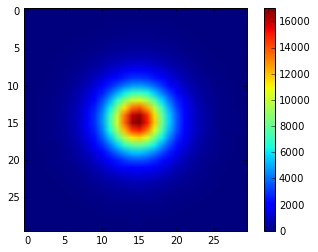

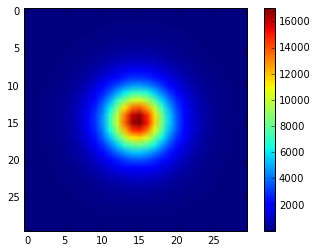

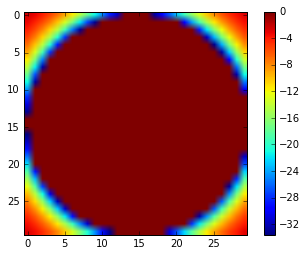

In [190]:
plt.figure()
plt.imshow(cropped_stamp.array)
plt.colorbar()
f = fish.image.array
plt.figure()
plt.imshow(f)
plt.colorbar()
plt.figure()
plt.imshow(cropped_stamp.array - f)
plt.colorbar()

In [165]:
print wld_model
print fish.model

galsim.Convolve(galsim.Exponential(scale_radius=0.345868148108, flux=1049961.07539).shift(-0.055495199978,-0.066240169092), galsim.Moffat(beta=3.0, scale_radius=0.686510711845))
(galsim.Convolve(galsim.Exponential(scale_radius=0.345868148108, flux=1049961.07539).shift(-0.055495199978,-0.066240169092), galsim.Moffat(beta=3.0, scale_radius=0.686510711845)))


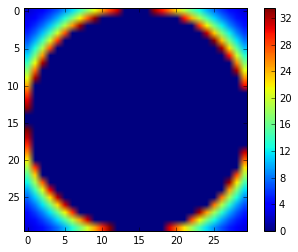

In [168]:
img1 = copy.deepcopy(wld_model.drawImage(image=stamp, use_true_center=False))
plt.figure()
plt.imshow(img1.array - cropped_stamp.array)
plt.colorbar()


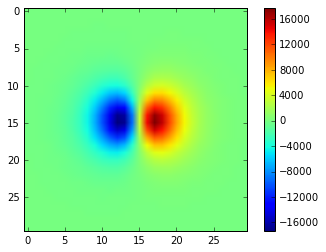

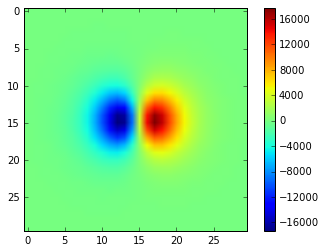

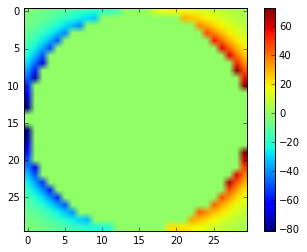

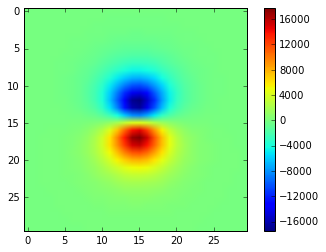

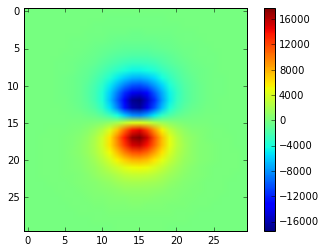

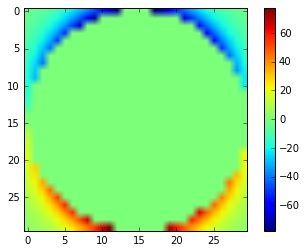

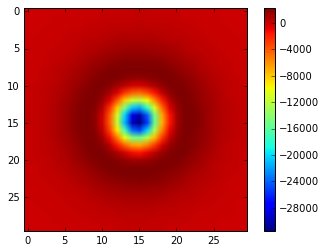

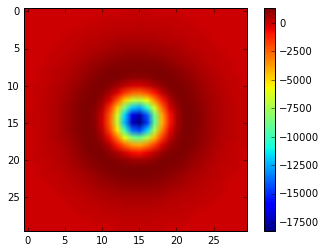

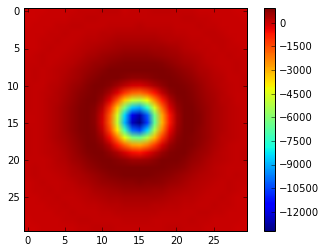

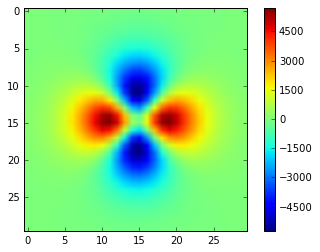

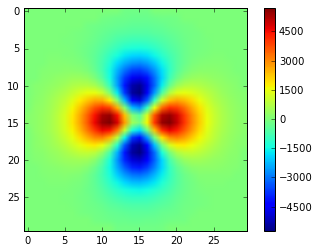

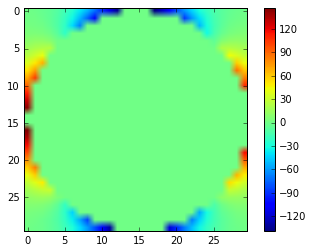

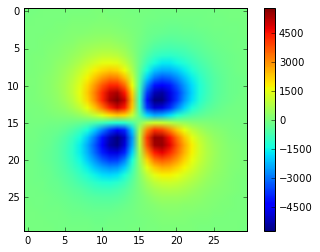

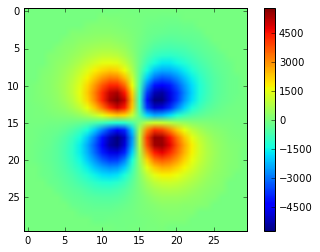

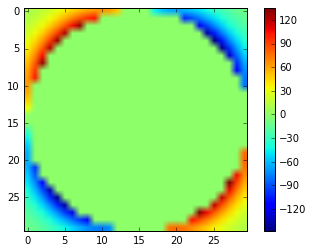

In [196]:
l = ['x0_1', 'y0_1', 'hlr_1', 'g1_1', 'g2_1']
for i,key in enumerate(l):
    
    plt.figure()
    plt.imshow(fish.derivatives_images[key])
    plt.colorbar()
    plt.figure()
    plt.imshow(fits[2].read()[i+1])
    plt.colorbar()
    plt.figure()
    plt.imshow(fish.derivatives_images[key] - fits[2].read()[i+1])
    plt.colorbar()